Import **Pytorch** libraries and APIs.


In [40]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')

    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')

    plt.show(block=True)


In [41]:
# Hyperparameters and Data loaders
num_epochs = 25
num_classes = 10
batch_size = 64
learning_rate = 0.002


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

In [42]:
# neural network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),

            nn.Linear(128, 64),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        out = self.classifier(x)

        return out


model=ConvNet()
model.cuda()
model.train()

ConvNet(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [43]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [44]:
model.train()
loss_list = []
acc_list = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))



Epoch [1/25], Step [0/938], Loss: 2.3020, Accuracy: 10.94%
Epoch [1/25], Step [150/938], Loss: 0.2334, Accuracy: 92.19%
Epoch [1/25], Step [300/938], Loss: 0.3179, Accuracy: 90.62%
Epoch [1/25], Step [450/938], Loss: 0.2129, Accuracy: 90.62%
Epoch [1/25], Step [600/938], Loss: 0.3445, Accuracy: 89.06%
Epoch [1/25], Step [750/938], Loss: 0.5505, Accuracy: 85.94%
Epoch [1/25], Step [900/938], Loss: 0.2080, Accuracy: 90.62%
Epoch [2/25], Step [0/938], Loss: 0.4635, Accuracy: 89.06%
Epoch [2/25], Step [150/938], Loss: 0.1786, Accuracy: 93.75%
Epoch [2/25], Step [300/938], Loss: 0.5682, Accuracy: 84.38%
Epoch [2/25], Step [450/938], Loss: 0.2201, Accuracy: 95.31%
Epoch [2/25], Step [600/938], Loss: 0.5594, Accuracy: 81.25%
Epoch [2/25], Step [750/938], Loss: 0.3857, Accuracy: 90.62%
Epoch [2/25], Step [900/938], Loss: 0.4625, Accuracy: 84.38%
Epoch [3/25], Step [0/938], Loss: 0.3878, Accuracy: 90.62%
Epoch [3/25], Step [150/938], Loss: 0.2993, Accuracy: 90.62%
Epoch [3/25], Step [300/938], 

In [45]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Accuracy of the model on the 10000 test images: 92.11 %


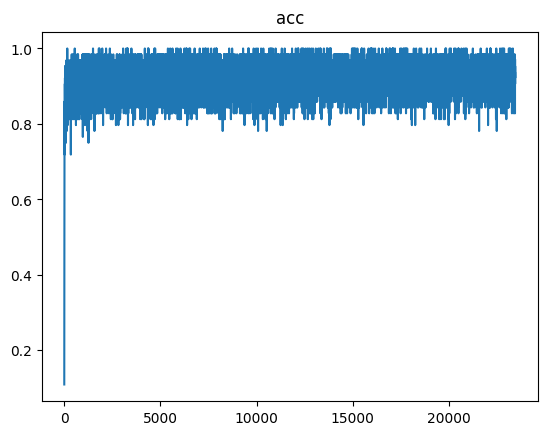

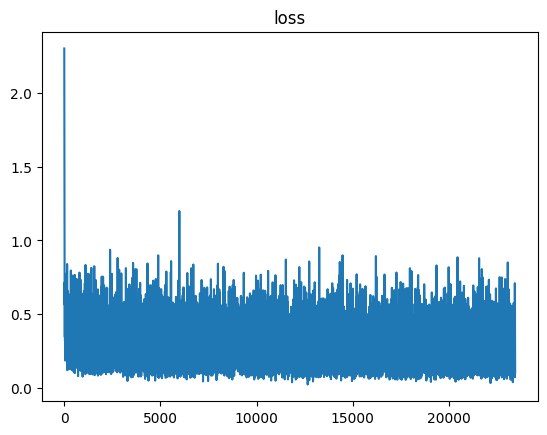

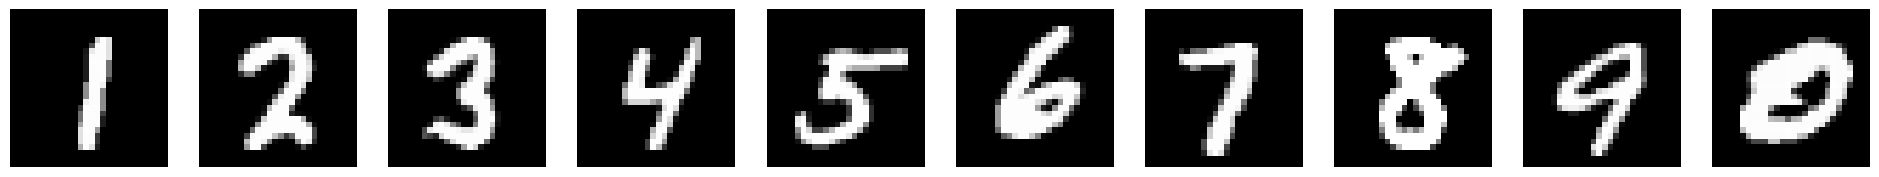

In [46]:
plt.figure()
plt.plot(acc_list)
plt.title('acc')

plt.figure()
plt.plot(loss_list)
plt.title('loss')

show_images(images[:10])

Incorrect Predictions:


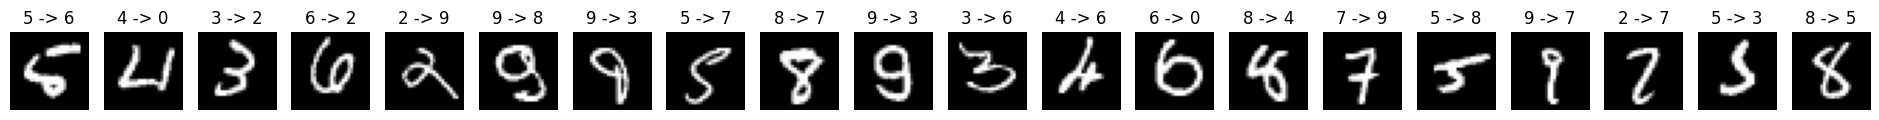

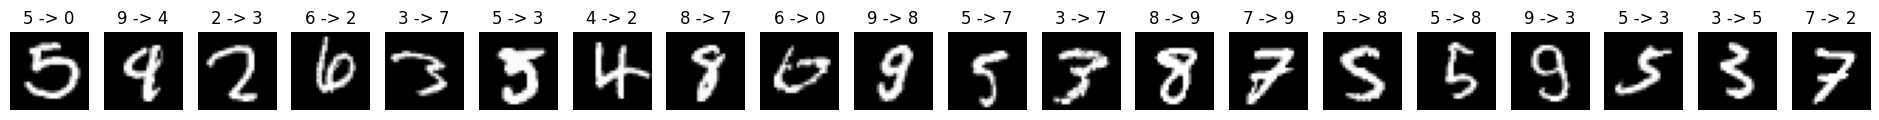

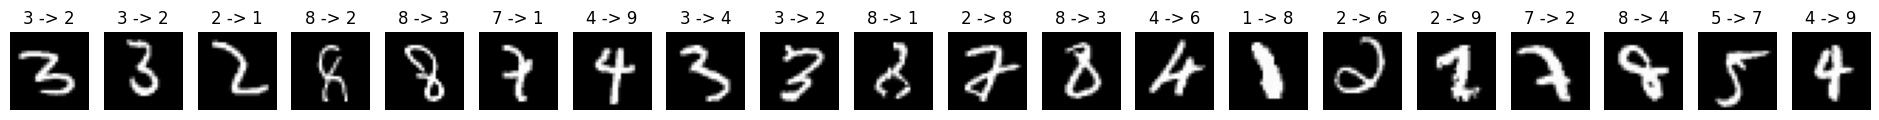

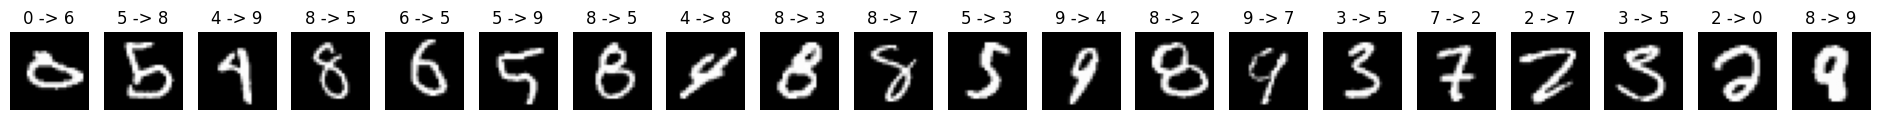


 
 Correct Predictions:


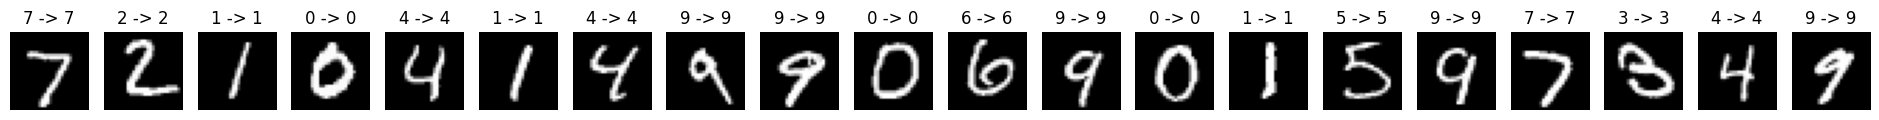

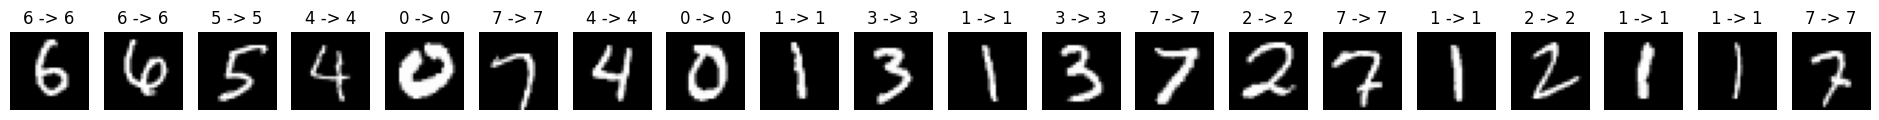

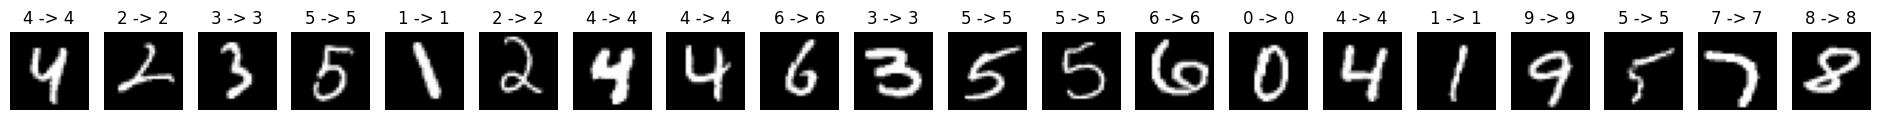

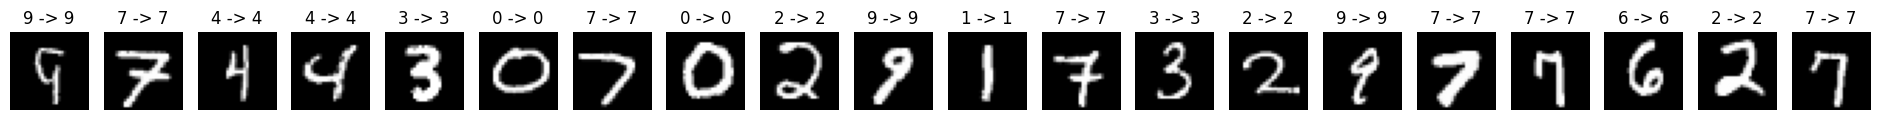

In [47]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for i, (images, labels) in enumerate(test_loader):
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      confidences = outputs.softmax(1)
      _, predicted = torch.max(outputs.data, 1)
      correct_idx = predicted == labels
      incorrect_idx = predicted != labels

      if i == 0:
        correct_images, correct_labels, correct_pred, correct_conf = images[correct_idx], labels[correct_idx], predicted[correct_idx], confidences[correct_idx]
        incorrect_images, incorrect_labels, incorrect_pred, incorrect_conf = images[incorrect_idx], labels[incorrect_idx], predicted[incorrect_idx], confidences[incorrect_idx]
      else:
        correct_images, correct_labels, correct_pred, correct_conf = torch.cat((correct_images, images[correct_idx]),0), torch.cat((correct_labels, labels[correct_idx]),0), torch.cat((correct_pred, predicted[correct_idx]),0), torch.cat((correct_conf, confidences[correct_idx]),0)
        incorrect_images, incorrect_labels, incorrect_pred, incorrect_conf = torch.cat((incorrect_images, images[incorrect_idx]),0), torch.cat((incorrect_labels, labels[incorrect_idx]),0), torch.cat((incorrect_pred, predicted[incorrect_idx]),0), torch.cat((incorrect_conf, confidences[incorrect_idx]),0)

print("Incorrect Predictions:")
plt_num = 20
for i in range(4):
  show_images_withPred(incorrect_images[i*plt_num:(i+1)*plt_num], incorrect_labels[i*plt_num:(i+1)*plt_num],incorrect_pred[i*plt_num:(i+1)*plt_num], correct_conf[i*plt_num:(i+1)*plt_num])

print("\n \n Correct Predictions:")
for i in range(4):
  show_images_withPred(correct_images[i*plt_num:(i+1)*plt_num], correct_labels[i*plt_num:(i+1)*plt_num],correct_pred[i*plt_num:(i+1)*plt_num], incorrect_conf[i*plt_num:(i+1)*plt_num])

del correct_images, correct_labels,correct_pred,correct_conf,incorrect_images,incorrect_labels,incorrect_pred,incorrect_conf

In [48]:
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3),

            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        out = self.features(x)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = F.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out) #logits for crossentropy loss


      # out = self.fc1(out)
       # out = self.fc2(out)
       # out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) #weight decay = L2 regularization

steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4
)

In [49]:
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/25], Step [0/938], Loss: 2.2900, Accuracy: 15.62%
Epoch [1/25], Step [150/938], Loss: 1.1933, Accuracy: 60.94%
Epoch [1/25], Step [300/938], Loss: 0.6841, Accuracy: 84.38%
Epoch [1/25], Step [450/938], Loss: 0.6053, Accuracy: 81.25%
Epoch [1/25], Step [600/938], Loss: 0.6159, Accuracy: 82.81%
Epoch [1/25], Step [750/938], Loss: 0.3742, Accuracy: 85.94%
Epoch [1/25], Step [900/938], Loss: 0.2579, Accuracy: 93.75%
Epoch [2/25], Step [0/938], Loss: 0.1801, Accuracy: 93.75%
Epoch [2/25], Step [150/938], Loss: 0.1006, Accuracy: 98.44%
Epoch [2/25], Step [300/938], Loss: 0.2822, Accuracy: 90.62%
Epoch [2/25], Step [450/938], Loss: 0.0847, Accuracy: 98.44%
Epoch [2/25], Step [600/938], Loss: 0.2292, Accuracy: 95.31%
Epoch [2/25], Step [750/938], Loss: 0.1945, Accuracy: 95.31%
Epoch [2/25], Step [900/938], Loss: 0.0832, Accuracy: 98.44%
Epoch [3/25], Step [0/938], Loss: 0.1374, Accuracy: 95.31%
Epoch [3/25], Step [150/938], Loss: 0.1616, Accuracy: 93.75%
Epoch [3/25], Step [300/938], 

Incorrect Predictions:


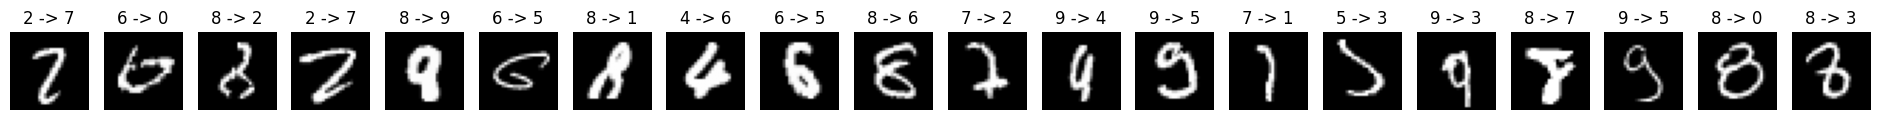

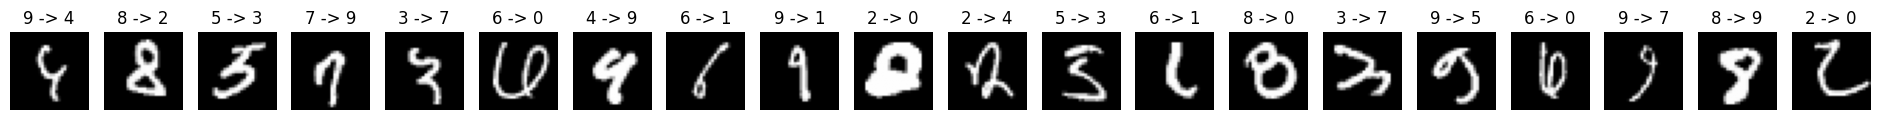

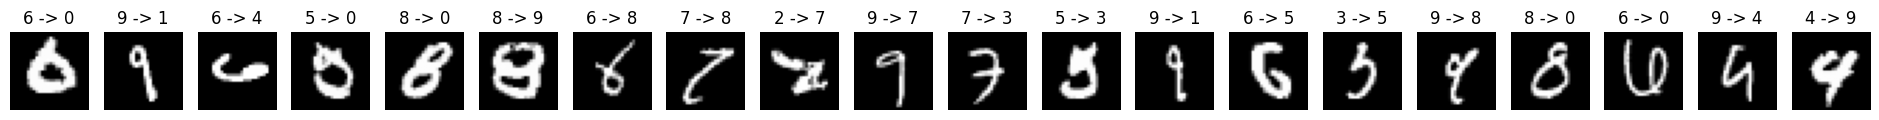

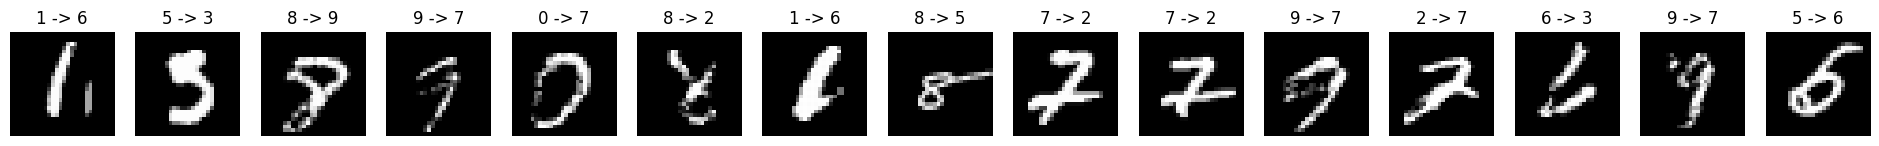



Correct Predictions:


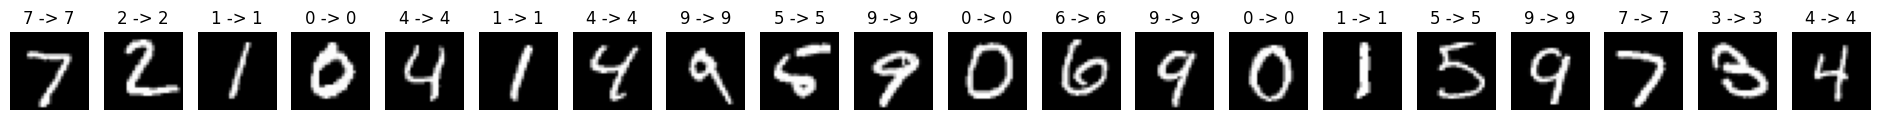

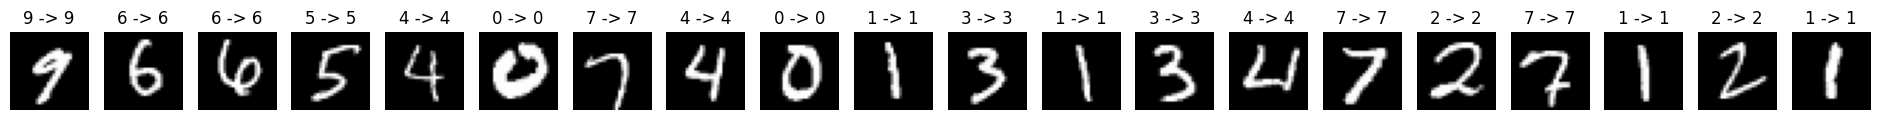

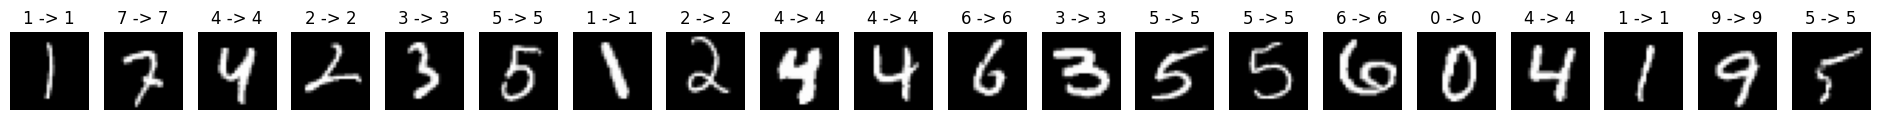

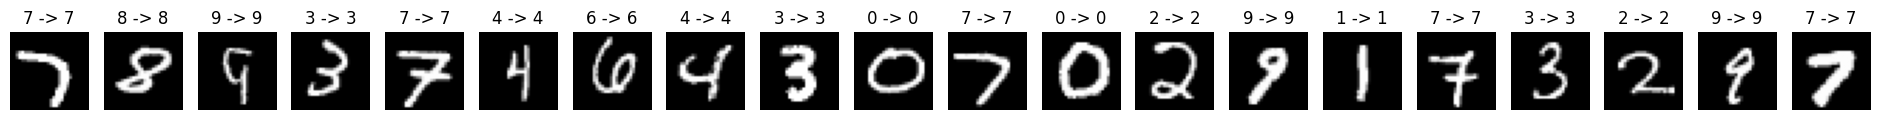

In [50]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        confidences = outputs.softmax(1)
        _, predicted = torch.max(outputs.data, 1)
        correct_idx = predicted == labels
        incorrect_idx = predicted != labels

        if i == 0:
            correct_images = images[correct_idx]
            correct_labels = labels[correct_idx]
            correct_pred = predicted[correct_idx]
            correct_conf = confidences[correct_idx]

            incorrect_images = images[incorrect_idx]
            incorrect_labels = labels[incorrect_idx]
            incorrect_pred = predicted[incorrect_idx]
            incorrect_conf = confidences[incorrect_idx]
        else:
            correct_images = torch.cat((correct_images, images[correct_idx]), 0)
            correct_labels = torch.cat((correct_labels, labels[correct_idx]), 0)
            correct_pred = torch.cat((correct_pred, predicted[correct_idx]), 0)
            correct_conf = torch.cat((correct_conf, confidences[correct_idx]), 0)

            incorrect_images = torch.cat((incorrect_images, images[incorrect_idx]), 0)
            incorrect_labels = torch.cat((incorrect_labels, labels[incorrect_idx]), 0)
            incorrect_pred = torch.cat((incorrect_pred, predicted[incorrect_idx]), 0)
            incorrect_conf = torch.cat((incorrect_conf, confidences[incorrect_idx]), 0)

print("Incorrect Predictions:")
plt_num = 20
for i in range(4):
    show_images_withPred(
        incorrect_images[i*plt_num:(i+1)*plt_num],
        incorrect_labels[i*plt_num:(i+1)*plt_num],
        incorrect_pred[i*plt_num:(i+1)*plt_num],
        incorrect_conf[i*plt_num:(i+1)*plt_num]
    )

print("\n\nCorrect Predictions:")
for i in range(4):
    show_images_withPred(
        correct_images[i*plt_num:(i+1)*plt_num],
        correct_labels[i*plt_num:(i+1)*plt_num],
        correct_pred[i*plt_num:(i+1)*plt_num],
        correct_conf[i*plt_num:(i+1)*plt_num]
    )

# Freeing memory by deleting large tensors after usage
del correct_images, correct_labels, correct_pred, correct_conf
del incorrect_images, incorrect_labels, incorrect_pred, incorrect_conf


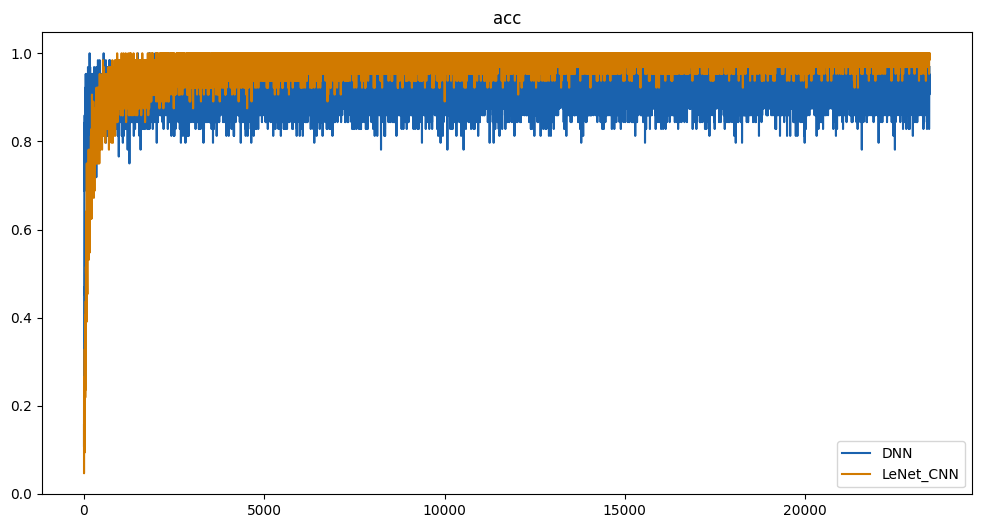

Text(0.5, 1.0, 'loss')

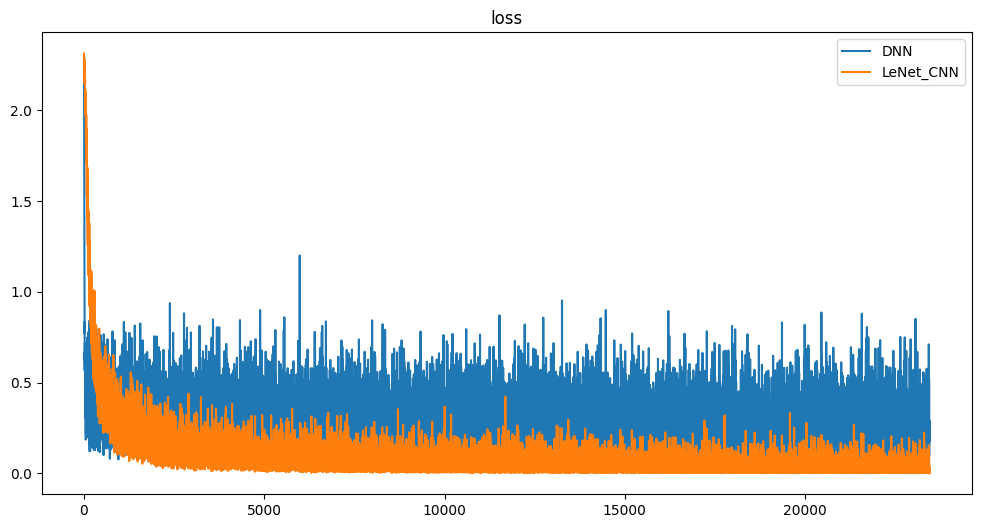

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(acc_list, color='#1A62AE')  # DNN color: Blue
plt.plot(acc_list_cnn, color='#D17A00')  # LeNet_CNN color: Orange
plt.legend(['DNN', 'LeNet_CNN'])
plt.title('acc')
plt.show()


plt.figure(figsize=(12,6))
plt.plot(loss_list)
plt.plot(loss_list_cnn)
plt.legend(['DNN','LeNet_CNN'])
plt.title('loss')

# **Homework**
